#  Final: Classifying news stories as true or fake

#### Randy Thompson, Ben Horvath

With the rise of social media, everyone has an equal opportunity to create, share and distribute articles of their choosing. Some of these articles are written without sources or evidence for the claims they make. These "fake news" articles may have patterns of text that can make them identifiable as real or fake.

Our goal is to classify whether a piece is fake or not _based on its substantive text content only_. The dataset is carefully prepared to remove any 'hints' to the model that detract from this goal (e.g., removing datelines).

The data can be downloaded from Kaggle at https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset. It is not present in the Github repo because of its size.

We make heavy use of tidyverse R functionality. Especially useful here is the `tidytext` package, which drastically simplifies the calculation of TF-IDF matrices; and the `caret` library for cross-validated modeling. Load necessary libraries:

In [3]:
library(caret)
library(dplyr)
library(ggplot2)
library(lubridate)  # easy dates
library(stringr)    # easy regex
library(textstem)   # stemming, lemmatization
library(tidytext)   # easy TF-IDF
library(tidyverse)
library(janitor)
library(topicmodels)
library(tm)

## Load the data

The data comes seperated in two CSVs of about equal size, one for true news stories, and other for fake. We load them, assign our dependent variable $y = \{fake, true\}$, and combine them.

In [4]:
fake <- read_csv('~/CUNY/DATA 620/final/Fake.csv') %>%
  mutate(y='fake')

real <- read_csv('~/CUNY/DATA 620/final/True.csv') %>%
  mutate(y='real')

# rename date to dt to keep R happy
df <- rbind(fake, real) %>%
  rename(dt = 'date') %>%
  mutate(dt = parse_date_time(dt, '%B %d, $Y'))

head(df, 1)

Parsed with column specification:
cols(
  title = col_character(),
  text = col_character(),
  subject = col_character(),
  date = col_character()
)

Parsed with column specification:
cols(
  title = col_character(),
  text = col_character(),
  subject = col_character(),
  date = col_character()
)

Warning message:
" 45 failed to parse."


title,text,subject,dt,y
<chr>,<chr>,<chr>,<dttm>,<chr>
Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,2017-12-31,fake


The dataset gives  us the title of the text, the text  itself, a classification of the news story, and the date of publishing.

## Exploratory analysis

Before modeling, we get to know our dataset more thoroughly. First, inspect the distribution of the dependent variable, which shows a balanced dataset.

In [5]:
table(df$y)


 fake  real 
23481 21417 

In [6]:
table(df$subject)


Government News       left-news     Middle-east            News        politics 
           1570            4459             778            9050            6841 
   politicsNews         US_News       worldnews 
          11272             783           10145 

The table below shows the distribution of subject these categories between fake and real news. We see that the fake news is labeled as either `politicsNews` or as `worldnews`, while the real news is labeled as everything else but those two. This suggests _subject should not be used as a model feature_.

In [7]:
prop.table(table(df$y, df$subject), 1)

      
       Government News  left-news Middle-east       News   politics
  fake      0.06686257 0.18989822  0.03313317 0.38541800 0.29134194
  real      0.00000000 0.00000000  0.00000000 0.00000000 0.00000000
      
       politicsNews    US_News  worldnews
  fake   0.00000000 0.03334611 0.00000000
  real   0.52631087 0.00000000 0.47368913

The `text` column will be ommitted in the NLP analysis because it is simply too much data for be easily computer on the present machines. However, we can still try to create simple features using regular expressions from the text. We examine a few of these below:

In [8]:
# Presence of Twitter handle
df$twitter_handle <- str_detect(df$text, '(?<!\\w)@[\\w+]{1,15}\\b')
prop.table(table(df$y, df$twitter_handle), 1)

      
            FALSE       TRUE
  fake 0.73419106 0.26580894
  real 0.98706575 0.01293425

The above shows that their is an association between the presence of a twitter handle and the reality of a news story.

Below shows a slighly weaker association with profanity (using a very crude and very incomplete regex):

In [9]:
PROFANITY <- 'fuck|shit|bastard|bitch|whore|goddamn'

df$profanity <- str_detect( tolower(df$text), PROFANITY)
prop.table(table(df$y, df$profanity), 1)

      
             FALSE        TRUE
  fake 0.942978425 0.057021575
  real 0.996964886 0.003035114

Finally, we can count the number of all-caps words in the text. Interestingly, there's no real difference in the distributions. Below we will see that this is due to the presence of acronyms in real news stories, as well as dateline in all-caps, e.g., WASHINGTON (Reuters). A better solution would be to count the length (in words) of all-caps phrases which do not appear often in real news stories.

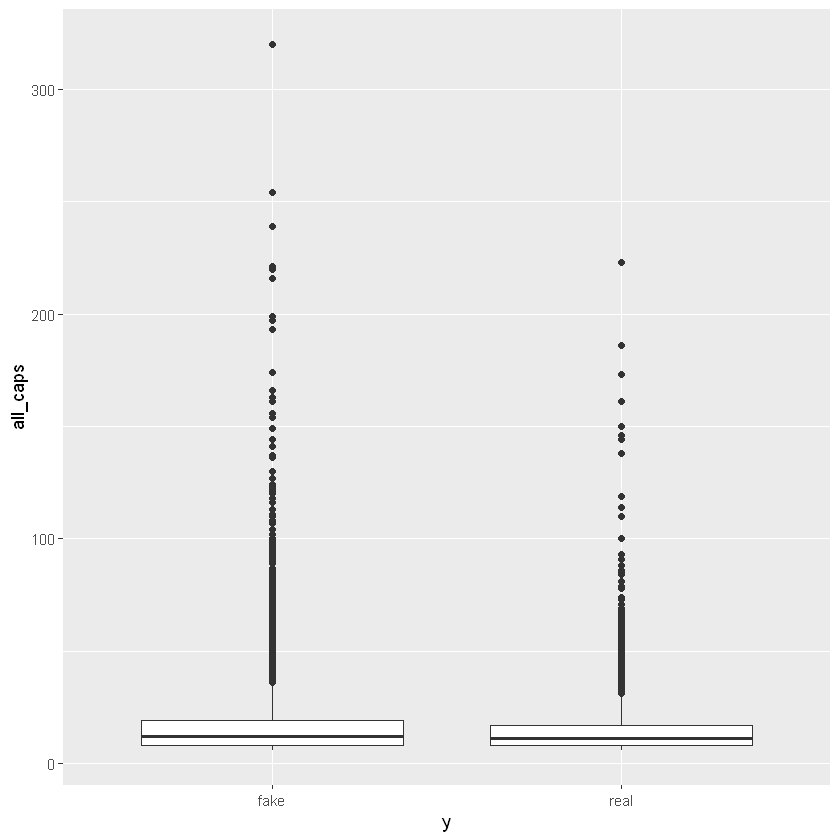

In [10]:
ALL_CAPS <- '(\\b[A-Z][A-Z]+|\\b[A-Z]\\b)'
df$all_caps <- str_count(df$text, ALL_CAPS)

ggplot(df %>% filter(all_caps > 5), aes(x=y, y=all_caps)) + geom_boxplot()

Finally, examine the distribution of fake and real news stories over time. There are no fake stories recorded until just after 2016, and following the spring of 2017 the real stories shoot up in quantity relative to the fake stories.

This could suggest the optimal sample should be  restricted to Jan. 2016 through June 2017, which would be about 26 thousand samples. 

Warning message:
"Removed 1 rows containing missing values (geom_path)."


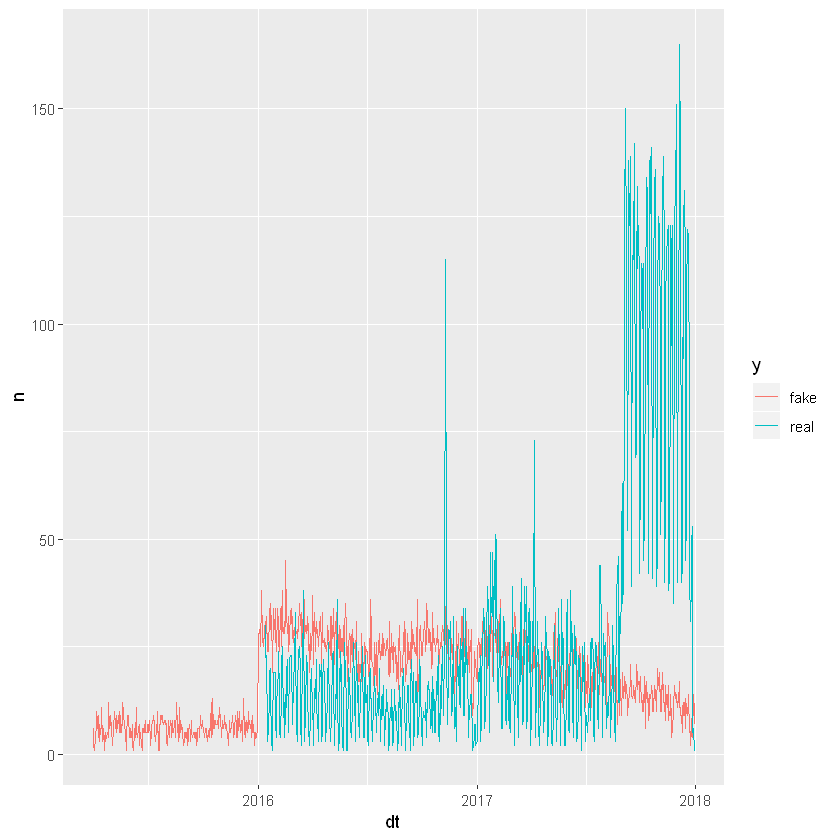

In [11]:
df %>%
  group_by(dt, y) %>%
  summarise(n=n_distinct(title)) %>%
  ggplot(aes(x=dt, y=n, colour=y)) + geom_line()

We will perform the same operations as above on the title:

In [12]:
df$title_twitter_handle <- str_detect(df$title, '(?<!\\w)@[\\w+]{1,15}\\b')
df$title_all_caps <- str_count(df$title, ALL_CAPS)
df$title_profanity <- str_detect( tolower(df$title), PROFANITY)

## Data cleaning

Using the story titles as IDs, there are duplicated stories. These are removed by keeping only the latest version:

In [13]:
length(df$title); length(unique(df$title))

[1] 44898

[1] 38728

In [14]:
df <- df %>%
  select(y, title, dt) %>% 
  arrange(title, desc(dt)) %>%
  group_by(title) %>%
  slice(which.max(dt)) %>% 
  filter(dt > date("2016-01-01") && dt < date("2017-07-01"))  %>% 
  ungroup()

length(df$title); length(unique(df$title))

[1] 21770

[1] 21770

All of the real news stories are from Reuters, and all Reuters news stories begin with a dateline, e.g., WASHINGTON (Rueters). These are removed by a very simple Regex that matches the beginning of the story up to the first hyphen. It appears to be effective enough. Additionally, we remove any other mentions of 'Reuters' just to be sure, and numbers:

In [15]:
df <- df %>%
  mutate(title = str_remove(title, '^[^\\-]*\\-\\s+'),
         title = str_remove(tolower(title), 'reuters'),
         title = str_remove(title, '[0-9]+'),
         title = str_remove(title, '[:punct:]+'),
         title = str_trim(title, side = "both"), 
         title = str_squish(title))

Often, at this point in NLP process, we normally remove punctuation and a list of stop words. However, it may be that there are differences in punctuations and stop words between fake and real news. We thus retain them.

### Test/Training Split

Now we're going to separate our test and training data. By keeping some data out of our model will ensure that we have data the model hasn't seen to get a sense of how our model will work on new data. 

In [41]:
indexed <- createDataPartition(df$y, p=0.5, list=FALSE, times=1)
df_train <- df[indexed,]
df_test <- df[-indexed,]

### Tokenize

However, we will be conducting other stemming, requiring tokenization. Recall that  we are concerned only with the title for now:

In [42]:
tokens <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  unnest_tokens(word, title, drop=FALSE) 


tokens2 <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  mutate(title2 = title) %>% 
  unnest_tokens(output = word, input = title2, token = "ngrams", n = 2) 

tokens3 <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  mutate(title2 = title) %>% 
  unnest_tokens(output = word, input = title2, token = "ngrams", n = 3) 

tokens <- rbind(tokens, tokens2, tokens3)

head(tokens)

y,title,word
<chr>,<chr>,<chr>
real,big bang theory' trumps tv audience for latest republican debate,big
real,big bang theory' trumps tv audience for latest republican debate,bang
real,big bang theory' trumps tv audience for latest republican debate,theory
real,big bang theory' trumps tv audience for latest republican debate,trumps
real,big bang theory' trumps tv audience for latest republican debate,tv
real,big bang theory' trumps tv audience for latest republican debate,audience


### Stemming

We will, of course, conduct stemming on the title, using the `textstem` library, which uses a stemmer based on the `libstemmer` C library developed in the early 2000s.

In [43]:
stems <- tokens %>%
  mutate(stemmed = stem_words(word))

head(stems)

y,title,word,stemmed
<chr>,<chr>,<chr>,<chr>
real,big bang theory' trumps tv audience for latest republican debate,big,big
real,big bang theory' trumps tv audience for latest republican debate,bang,bang
real,big bang theory' trumps tv audience for latest republican debate,theory,theori
real,big bang theory' trumps tv audience for latest republican debate,trumps,trump
real,big bang theory' trumps tv audience for latest republican debate,tv,tv
real,big bang theory' trumps tv audience for latest republican debate,audience,audienc


###  Lemmatize

Next, we clean up the tokens further by lemmatization, again using the `textstem` library:

In [44]:
lemmas <- stems %>%
  mutate(lemma = lemmatize_words(stemmed))

head(lemmas)

y,title,word,stemmed,lemma
<chr>,<chr>,<chr>,<chr>,<chr>
real,big bang theory' trumps tv audience for latest republican debate,big,big,big
real,big bang theory' trumps tv audience for latest republican debate,bang,bang,bang
real,big bang theory' trumps tv audience for latest republican debate,theory,theori,theori
real,big bang theory' trumps tv audience for latest republican debate,trumps,trump,trump
real,big bang theory' trumps tv audience for latest republican debate,tv,tv,tv
real,big bang theory' trumps tv audience for latest republican debate,audience,audienc,audienc


## Feature engineering

**ADD ADDITIONAL FEATURES HERE, INCORPORATE FROM ABOVE?**

Now we  calculate TF-IDF. Those scores and all other features are incorporated to a data frame called `X` for later machine learning.

In [45]:
token_count <- lemmas %>%
  count(title, y, lemma, sort=TRUE) %>%
  ungroup()
head(token_count)

title,y,lemma,n
<chr>,<chr>,<chr>,<int>
a must watch judge napolitano: “for the first time in the modern era the man in the oval office is an adversary of the deep state and not a tool of it” [video],fake,the,5
"mother of son killed in afghanistan to antiamerican er’s qb colin kaepernick: “my heart is exploding, my lungs are without air, my blood is boiling, my body is shaking, and tears are running down my face” [video]",fake,my,5
"trumps latest appointee is a climate denier, a racist, a birther, a homophobe, and an islamophobe",fake,a,5
whoa black woman fed up with black racists nails it: “many black people voted for barack obama simply because he was black…and now your black god has failed you!” [video],fake,black,5
"andrew breitbart “i don’t care who our candidate is…i will march behind whoever our candidate is, because if we don’t…we lose!”[video]",fake,i,4
"democrats chant warning to gop as trumpcare passes na na na na, hey hey hey, goodbye! (video)",fake,na,4


In [46]:
total_words <- token_count %>%
  group_by(title, y) %>%
  summarise(total = sum(n), .groups='keep')
head(total_words)

title,y,total,.groups
<chr>,<chr>,<int>,<chr>
000 ma drug cases could be thrown out because of drug stealing lab scandal,fake,39,keep
700 syrian refugees approved resettlement to u.s.: homeland security chief,real,27,keep
a $000 free-for-all for minorities in the biggest obama scandal yet,fake,36,keep
a bipartisan miracle: federal employee health plans add critical autism benefit,fake,30,keep
a breakfast in harlem underscores key challenge for white house hopeful sanders,real,33,keep
a bunch of dumb white racists will picket nfl offices because beyonce gave them butthurt images),fake,45,keep


In [47]:
token_count <- token_count %>%
  bind_tf_idf(lemma, title, n)

# Remove tokens with less than 10 instances
tc <- token_count %>%
  group_by(lemma) %>%
  summarise(n=sum(n), .groups='keep') %>%
  filter(n > 10)

token_count <- token_count %>%
  filter(lemma %in% tc$lemma)

head(token_count)

title,y,lemma,n,tf,idf,tf_idf
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
a must watch judge napolitano: “for the first time in the modern era the man in the oval office is an adversary of the deep state and not a tool of it” [video],fake,the,5,0.05208333,1.856464,0.09669081
"mother of son killed in afghanistan to antiamerican er’s qb colin kaepernick: “my heart is exploding, my lungs are without air, my blood is boiling, my body is shaking, and tears are running down my face” [video]",fake,my,5,0.04629630,5.250619,0.24308420
"trumps latest appointee is a climate denier, a racist, a birther, a homophobe, and an islamophobe",fake,a,5,0.11111111,1.887567,0.20972962
whoa black woman fed up with black racists nails it: “many black people voted for barack obama simply because he was black…and now your black god has failed you!” [video],fake,black,5,0.05555556,3.691551,0.20508618
"andrew breitbart “i don’t care who our candidate is…i will march behind whoever our candidate is, because if we don’t…we lose!”[video]",fake,i,4,0.05797101,2.472563,0.14333696
"melania thanks troops for sacrifices at easter egg rollflashback to : “peanut crew” had to remind michelle obama to mention troops, after using easter speech to brag about all of their accomplishments [video]",fake,to,4,0.04301075,1.092284,0.04697996


In [48]:
# Make into a wide, tidy data frame for machine learning
X <- token_count %>%
  select(title, y, lemma, tf_idf) %>% 
  filter(lemma != 'title',
         lemma != 'y') %>%  # remove because I'm already using 'title' and 'y'
  unique() %>%  
  tidyr::spread(lemma, tf_idf) %>%
  janitor::clean_names() %>%  # VERY HANDY FUNCTION!
  replace(is.na(.), 0) %>%
  select(-contains('_2'))

In [49]:
dim(X)
head(X[, c(1,2,601, 709, 804, 945)])
prop.table(table(X$y))

[1] 10868  2607

title,y,doe,face,forward,here
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
000 ma drug cases could be thrown out because of drug stealing lab scandal,fake,0,0,0,0
700 syrian refugees approved resettlement to u.s.: homeland security chief,real,0,0,0,0
a $000 free-for-all for minorities in the biggest obama scandal yet,fake,0,0,0,0
a bipartisan miracle: federal employee health plans add critical autism benefit,fake,0,0,0,0
a breakfast in harlem underscores key challenge for white house hopeful sanders,real,0,0,0,0
a bunch of dumb white racists will picket nfl offices because beyonce gave them butthurt images),fake,0,0,0,0



     fake      real 
0.6224696 0.3775304 

Our final TF-IDF matrix has almost 39,000 articles (rows), 4156 token TF-IDF scores (columns), and a reasonably balanced distribution of fake and real news.

**ADD ADDITIONAL FEATURES HERE!**

## Modeling

With almost 14,000 potential variable, we would like to drop those to a more reasonable set. First, remove low variance using the ratio of a variable's unique values to its sample size. By default, `nearZeroVar` suggests all the variables have sparse variancel; this is fixed by modifying the default value for `uniqueCut`:

In [50]:
# Remove low variance variables
low_variance <- nearZeroVar(X, uniqueCut=.12)
print(low_variance)

   [1]    3    8    9   10   12   13   14   15   16   17   18   19   20   21
  [15]   22   23   24   25   28   29   30   31   32   33   35   37   39   40
  [29]   41   42   43   46   48   49   51   53   54   55   58   59   60   61
  [43]   63   64   65   66   68   69   70   71   72   74   78   81   83   84
  [57]   85   87   88   90   91   93   94   95   98   99  100  102  104  105
  [71]  106  107  110  111  113  114  115  116  118  119  120  121  122  124
  [85]  125  126  127  131  134  136  138  139  140  141  142  143  145  148
  [99]  150  151  153  155  156  159  160  161  162  163  165  166  167  168
 [113]  171  172  173  175  177  179  185  186  188  189  191  192  194  195
 [127]  197  198  199  201  202  203  204  206  208  210  211  213  214  215
 [141]  216  218  220  221  222  224  226  227  229  231  232  233  234  235
 [155]  238  239  240  241  242  243  246  249  250  251  252  255  256  257
 [169]  261  262  263  266  268  269  271  272  274  275  276  279  282  284

In [51]:
length(low_variance)

[1] 1770

In [52]:
X <- X[,-low_variance]
ncol(X)

[1] 837

### Random Forest

**TEMPLATE FOR MODELING**

Using the `ranger`  package, a faster and more modern implementation of random forests

Maximize for ROC:

In [53]:
ctrl <- trainControl(method='repeatedcv',
                     number=2,  # number of folds for each run: change this for final run
                     repeats=1,  # number of times to repeat CV: change this for final run
                     classProbs=TRUE,
                     savePredictions=TRUE,
                     summaryFunction = twoClassSummary)

# good guesses for mtry are sqrt(p) and log2(p)
tunegrid <- expand.grid(mtry=c(9, 20),
                        splitrule=c('gini'),
                        min.node.size=c(1, 5))
 
set.seed(1804)
m0 <- train(y ~ .,
            data=X, 
            tuneGrid=tunegrid,
            method='ranger',
            num.trees=1000,
            importance='impurity',
            trControl=ctrl,
            metric='ROC')

print(m0)



Growing trees.. Progress: 75%. Estimated remaining time: 10 seconds.
Growing trees.. Progress: 77%. Estimated remaining time: 9 seconds.
Growing trees.. Progress: 75%. Estimated remaining time: 10 seconds.
Growing trees.. Progress: 80%. Estimated remaining time: 7 seconds.
Growing trees.. Progress: 20%. Estimated remaining time: 2 minutes, 2 seconds.
Growing trees.. Progress: 39%. Estimated remaining time: 1 minute, 39 seconds.
Growing trees.. Progress: 59%. Estimated remaining time: 1 minute, 5 seconds.
Growing trees.. Progress: 78%. Estimated remaining time: 34 seconds.
Growing trees.. Progress: 98%. Estimated remaining time: 2 seconds.
Random Forest 

10868 samples
  836 predictor
    2 classes: 'fake', 'real' 

No pre-processing
Resampling: Cross-Validated (2 fold, repeated 1 times) 
Summary of sample sizes: 5434, 5434 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec        
   9    1              0.9687565  1.0000000  0.0004875670
  

In [54]:
print(m0)

Random Forest 

10868 samples
  836 predictor
    2 classes: 'fake', 'real' 

No pre-processing
Resampling: Cross-Validated (2 fold, repeated 1 times) 
Summary of sample sizes: 5434, 5434 
Resampling results across tuning parameters:

  mtry  min.node.size  ROC        Sens       Spec        
   9    1              0.9687565  1.0000000  0.0004875670
   9    5              0.9683196  1.0000000  0.0002436647
  20    1              0.9723203  0.9642274  0.7957597825
  20    5              0.9719737  0.9649666  0.7962474683

Tuning parameter 'splitrule' was held constant at a value of gini
ROC was used to select the optimal model using the largest value.
The final values used for the model were mtry = 20, splitrule = gini
 and min.node.size = 1.


In [55]:
# shows the performance on each repetition of the modeling proess
# can get mean performance, std dev of each performance, or plot
# a histogram, giving complete overview of performance on multiple
# slices and dices of the training dataset
head(m0$resample)

# Averaged cross-validation scores, most representative of performance
mean(m0$resample$ROC); mean(m0$resample$Sens); mean(m0$resample$Spec)

,ROC,Sens,Spec,Resample
,<dbl>,<dbl>,<dbl>,<chr>
1,0.9739077,0.9660065,0.7981472,Fold1.Rep1
2,0.9707329,0.9624483,0.7933723,Fold2.Rep1


[1] 0.9723203

[1] 0.9642274

[1] 0.7957598

In [56]:
varImp(m0)

ranger variable importance

  only 20 most important variables shown (out of 11702)

           Overall
video       100.00
u            57.75
trump        44.42
to           38.35
the          38.09
sai          33.79
hous         31.62
on           20.44
senat        20.30
watch        19.03
`in`         17.95
and          16.61
republican   14.85
`for`        14.57
just         14.56
white_hous   14.33
hillari      14.05
i            13.91
hello        12.18
white        11.90

Warning message:
"package 'Hmisc' was built under R version 3.6.3"
Loading required package: survival

Warning message:
"package 'survival' was built under R version 3.6.3"

Attaching package: 'survival'


The following object is masked from 'package:caret':

    cluster


Loading required package: Formula


Attaching package: 'Hmisc'


The following object is masked from 'package:koRpus':

    describe


The following object is masked from 'package:sylly':

    describe


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    format.pval, units




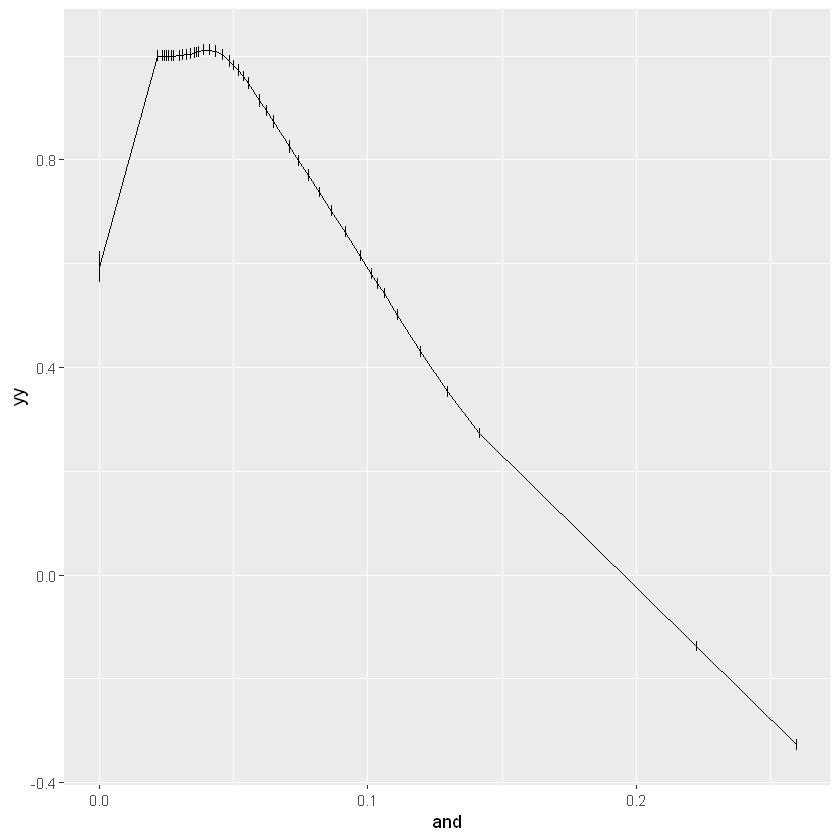

In [57]:
# This is a conveniant way to visualize 'direct probabilities' from the raw data,
# (NOT the model)

Y <- X %>%
  mutate(yy = if_else(y == 'fake', TRUE, FALSE))  # has to be a factor for Hmisc

library(Hmisc)
ggplot(Y, aes(x=and, y=yy )) +
histSpikeg(yy ~ and, lowess=TRUE, data=Y)

In [61]:
tokens <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  unnest_tokens(word, title, drop=FALSE) %>% 
  filter(!word %in% stop_words$word)


tokens2 <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  mutate(title2 = title) %>% 
  unnest_tokens(output = bigram, input = title2, token = "ngrams", n = 2) %>% 
  separate(bigram, c("word1", "word2"), sep = " ") %>% 
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word) %>% 
  unite(word, word1, word2, sep = " ") %>% 
  filter(!word == "NA NA")

tokens3 <- df_train %>%
  select(y, title) %>%
  unique() %>% 
  mutate(title2 = title) %>% 
  unnest_tokens(output = trigram, input = title2, token = "ngrams", n = 3) %>% 
  separate(trigram, c("word1", "word2", "word3"), sep = " ") %>% 
  filter(!word1 %in% stop_words$word) %>%
  filter(!word2 %in% stop_words$word) %>% 
  filter(!word3 %in% stop_words$word) %>%
  unite(word, word1, word2, word3, sep = " ") %>% 
  filter(!word == "NA NA NA")

words <- rbind(tokens, tokens2, tokens3)



In [62]:
token_count <- words %>%
  mutate(stemmed = stem_words(word))%>%
  mutate(lemma = lemmatize_words(stemmed)) %>% 
  count(title, y, lemma, sort=TRUE) %>%
  ungroup() %>% 
  group_by(title, y) %>%
  summarise(total = sum(n), .groups='keep') %>% 
  bind_tf_idf(lemma, title, n)

tc <- token_count %>%
  group_by(lemma) %>%
  summarise(n=sum(n), .groups='keep') %>%
  filter(n > 10)

token_count <- token_count %>%
  filter(lemma %in% tc$lemma)



ERROR: Error in parse(text = x, srcfile = src): <text>:35:0: unexpected end of input
33:   RMSE = caret::RMSE(pred_m0, df_test$y),
34:   Rsquare = caret::R2(pred_m0, df_test$y))
   ^


In [63]:
df_test_X <- token_count %>%
  select(title, y, lemma, tf_idf) %>% 
  filter(lemma != 'title',
         lemma != 'y') %>%  # remove because I'm already using 'title' and 'y'
  unique() %>%  
  tidyr::spread(lemma, tf_idf) %>%
  janitor::clean_names() %>%  # VERY HANDY FUNCTION!
  replace(is.na(.), 0) %>%
  select(!contains('_2'))



In [67]:
pred_m0 <- predict(m0, df_test_X)


ERROR: Error in parse(text = x, srcfile = src): <text>:8:0: unexpected end of input
6:   RMSE = caret::RMSE(pred_m0, df_test_X$y),
7:   Rsquare = caret::R2(pred_m0, df_test_X$y))
  ^


In [108]:
df_test_X$y <- as.factor(df_test_X$y)
pred_m0 <- as.factor(pred_m0)


 Factor w/ 2 levels "fake","real": 1 2 1 2 2 1 1 1 1 2 ...


In [109]:
#df_test_X$y <- as.character(df_test_X$y)
confusionMatrix(pred_m0, df_test_X$y)

Confusion Matrix and Statistics

          Reference
Prediction fake real
      fake 6496  411
      real  269 3692
                                          
               Accuracy : 0.9374          
                 95% CI : (0.9327, 0.9419)
    No Information Rate : 0.6225          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.866           
                                          
 Mcnemar's Test P-Value : 6.405e-08       
                                          
            Sensitivity : 0.9602          
            Specificity : 0.8998          
         Pos Pred Value : 0.9405          
         Neg Pred Value : 0.9321          
             Prevalence : 0.6225          
         Detection Rate : 0.5977          
   Detection Prevalence : 0.6355          
      Balanced Accuracy : 0.9300          
                                          
       'Positive' Class : fake            
                        

,pred_m0
fake,fake
real,real
fake,fake
fake,real
real,real
fake,fake
fake,fake
fake,fake
fake,fake
real,real
